<h2>Text Classification Model</h2>

<h4>Preprocessing</h4>

In [1]:
# packages used
import pdftotext
import json
import os
import glob
import pandas as pd
import numpy as np

In [22]:
old_pdfs = glob.glob('docs1/raw_data/*.pdf')
new_pdfs = glob.glob('docs1/new/*.pdf')
docs = glob.glob('docs/*.pdf')
capital = glob.glob('capital/*.pdf') # 224 files
factsheet = glob.glob('factsheet/*.pdf') # 550
investor_letter = glob.glob('524 Investor Letter/*.pdf') # 523

In [23]:
print(len(old_pdfs), len(new_pdfs), len(docs), len(capital), len(factsheet), len(investor_letter))

276 100 500 224 550 523


In [24]:
len(old_pdfs)+len(new_pdfs)+len(capital)+len(factsheet)+len(investor_letter)+len(docs)

2173

In [5]:
cat = [] # categories
filenames = [] # files
for pdf in old_pdfs+new_pdfs:
    filenames.append(pdf)
    if 'Account Statement' in pdf:
        cat.append(1)
    elif 'Distribution Notice' in pdf:
        cat.append(2)
    elif 'Call Notice' in pdf:
        cat.append(3)
    else:
        cat.append(0)

In [6]:
print(len(cat), len(filenames))

376 376


In [7]:
text = [] # text extracted from files
for file in filenames:
    content = ''
    with open(file, 'rb') as f:
        pages = pdftotext.PDF(f)
        for page in pages:
            content += page
    text.append(content)

In [8]:
with open('500 Account Statements Extracted Data.json', 'r') as f:
    extracted_data = f.read()
    
extracted_data = json.loads(extracted_data)
for file in extracted_data:
    if file['subCategory'] == 'Account Statement' in pdf:
        cat.append(1)
    elif file['subCategory'] == 'Distribution Notice' in pdf:
        cat.append(2)
    elif file['subCategory'] == 'Call Notice' in pdf:
        cat.append(3)
    else:
        cat.append(0)

In [9]:
for file in extracted_data:
    content = ''
    with open('docs/' + file['id'] + '.pdf', 'rb') as f:
        pages = pdftotext.PDF(f)
        for page in pages:
            content += page
    text.append(content)

In [10]:
for file in capital:
    cat.append(3)
    content = ''
    with open(file, 'rb') as f:
        pages = pdftotext.PDF(f)
        for page in pages:
            content += page
    text.append(content)

In [11]:
for file in factsheet:
#     cat.append(0)
    content = ''
    with open(file, 'rb') as f:
        try:
            pages = pdftotext.PDF(f)
            for page in pages:
                content += page
            text.append(content)
            cat.append(0)
        except:
            continue
## missing two from factsheet

In [12]:
for file in investor_letter:
#     cat.append(0)
    content = ''
    with open(file, 'rb') as f:
        try:
            pages = pdftotext.PDF(f)
            for page in pages:
                content += page
            text.append(content)
            cat.append(0)
        except:
            continue
## 13 missing

In [13]:
print(len(cat), len(text))

2158 2158


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
d = {'category': cat, 'text': text}
df = pd.DataFrame(data=d)

In [30]:
df.category.value_counts()

0    1578
3     305
1     240
2      35
Name: category, dtype: int64

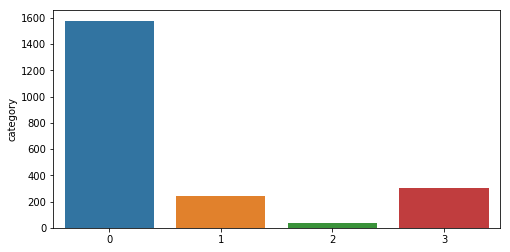

In [32]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['category'].value_counts().index, y=df['category'].value_counts())
plt.show()

<h4>Train and Test</h4>

In [21]:
# df

In [56]:
df.to_csv('all.csv', index=False)

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [34]:
text_list = df['text'].tolist()
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(text_list)

In [35]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [36]:
varietal_list = df['category'].tolist()
train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, varietal_list, test_size=0.3)

#### SVM

In [37]:
clf = SVC(kernel='linear', class_weight='balanced').fit(train_x, train_y)
y_score = clf.predict(test_x)

In [38]:
np.mean(y_score == test_y)

0.9429012345679012

In [39]:
# training error
np.mean(clf.predict(train_x)==train_y)

0.9357615894039735

In [40]:
f1_score(test_y, y_score, average="weighted")

0.9469504942373159

#### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf_RF = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0).fit(train_x, train_y)
y_RF = clf_RF.predict(test_x)

In [47]:
clf_RF

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [48]:
np.mean(y_RF == test_y)

0.9259259259259259

In [49]:
# training error
np.mean(clf_RF.predict(train_x)==train_y)

0.9841059602649007

In [50]:
f1_score(test_y, y_RF, average="weighted")

0.9253490908429308

#### KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
neigh = KNeighborsClassifier(n_neighbors=2).fit(train_x, train_y)
y_KNN = neigh.predict(test_x)

In [71]:
# test K
test_accuracy = []
training_accuracy = []
for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y)
    y_KNN = neigh.predict(test_x)
    test_accuracy.append(np.mean(y_KNN == test_y))
    training_accuracy.append(np.mean(neigh.predict(train_x)==train_y))

In [72]:
test_accuracy

[0.9320987654320988,
 0.9197530864197531,
 0.9259259259259259,
 0.9120370370370371,
 0.9135802469135802,
 0.8981481481481481,
 0.9027777777777778,
 0.8919753086419753,
 0.8950617283950617]

In [73]:
training_accuracy

[0.9841059602649007,
 0.9662251655629139,
 0.9675496688741722,
 0.9556291390728476,
 0.956953642384106,
 0.9483443708609272,
 0.9470198675496688,
 0.9357615894039735,
 0.9337748344370861]

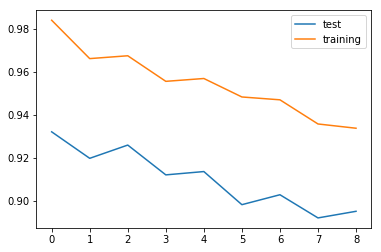

In [79]:
plt.plot(test_accuracy, label='test')
plt.plot(training_accuracy, label='training')
plt.legend()
plt.show()

In [81]:
np.mean(y_KNN == test_y)

0.9197530864197531

In [82]:
# training error
np.mean(neigh.predict(train_x)==train_y)

0.9662251655629139

In [83]:
f1_score(test_y, y_KNN, average="weighted")

0.9145923233166239

#### Comparison

In [56]:
alg = ['SVM', 'Random Forest', 'KNN']
acc_test = [0.943, 0.925, 0.914]
acc_train = [0.936, 0.984, 0.957]
f1 = [0.925, 0.925, 0.913]

In [57]:
df_compare = pd.DataFrame(index=alg, columns=['Test Accuracy', 'Training Accuracy', 'f1 score'], 
                          data=[acc_test, acc_train, f1])

In [58]:
df_compare

,Test Accuracy,Training Accuracy,f1 score
SVM,0.943,0.925,0.914
Random Forest,0.936,0.984,0.957
KNN,0.925,0.925,0.913
